# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import mlflow
from collections import defaultdict
from scipy.stats import zscore

# original library

import common as com
import pytorch_modeler as modeler
from pytorch_model import LSTM_AutoEncoder as Model
from pytorch_utils import filtered_load_model
import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
#with open("./config.yaml", 'rb') as f:
#    config = yaml.load(f)

log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/working/research/dcase2020/result/2D/LSTM3_CONV2_AE/config.yaml'

## make path list and train/valid split

In [7]:
############################################################################
# make path set and train/valid split
############################################################################
'''
train_paths[machine_type]['train' or 'valid'] = path
'''
dev_train_paths = {}
add_train_paths = {}
train_paths = {}

In [8]:
for machine_type in machine_types:
    # dev train
    dev_train_paths = ["{}/{}/train/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(dev_path, machine_type))]
    dev_train_paths = sorted(dev_train_paths)
    # add_dev train
    add_train_paths = ["{}/{}/train/".format(add_dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(add_dev_path, machine_type))]
    add_train_paths = sorted(add_train_paths)
    # valid
    dev_valid_paths = ["{}/{}/test/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/test".format(dev_path, machine_type))]
    dev_valid_paths = sorted(dev_valid_paths)
    
    train_paths[machine_type] = {}
    train_paths[machine_type]['train'] = dev_train_paths + add_train_paths
    train_paths[machine_type]['valid'] = dev_valid_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(train_paths, machine_type)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)         # debug
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['preprocessing']['sample_rate'],
                window_size=config['preprocessing']['window_size'],
                hop_size=config['preprocessing']['hop_size'],
                mel_bins=config['preprocessing']['mel_bins'],
                fmin=config['preprocessing']['fmin'],
                fmax=config['preprocessing']['fmax'])
    #pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
    #net = filtered_load_model(net, pretrained_dict)
    optimizer = optim.Adam(net.parameters(), lr=1e-2)
    criterion = nn.MSELoss()
    num_epochs = config['fit']['num_epochs']
    history = modeler.train_net(net, dataloaders_dict, criterion, optimizer, num_epochs, writer)
    # output
    model = history['model']
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    torch.save(model.state_dict(), model_out_path)
    logger.info('\n success:{0} \n'.format(machine_type) + \
                    'model_out_path ==> \n {0}'.format(model_out_path))
    #  close writer for tensorbord
    writer.close()
    #modeler.mlflow_log(history, config, machine_type, model_out_path, tb_log_dir)
    com.toc()
    return history

In [10]:
machine_types

['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

2020-11-05 00:09:21,078 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2020-11-05 00:09:21,079 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-05 00:09:22,196 - 00_train.py - INFO - TRAINING


use: cuda:0


100%|██████████| 1803/1803 [00:30<00:00, 59.16it/s]


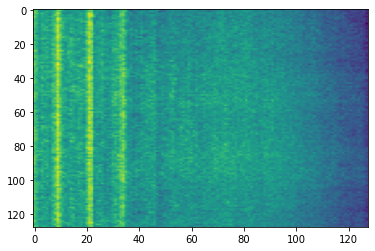

2020-11-05 00:10:35,048 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:85.148376, valid_AUC:0.544236, valid_pAUC:0.501913
100%|██████████| 1803/1803 [00:30<00:00, 59.38it/s]
2020-11-05 00:11:45,275 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:21.621299, valid_AUC:0.472302, valid_pAUC:0.507428
100%|██████████| 1803/1803 [00:30<00:00, 58.80it/s]
2020-11-05 00:12:55,405 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:20.027518, valid_AUC:0.530792, valid_pAUC:0.500319
100%|██████████| 1803/1803 [00:30<00:00, 59.00it/s]
2020-11-05 00:14:06,022 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:17.970642, valid_AUC:0.515298, valid_pAUC:0.506077
100%|██████████| 1803/1803 [00:30<00:00, 59.31it/s]
2020-11-05 00:15:15,815 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:16.418800, valid_AUC:0.533475, valid_pAUC:0.505758
100%|██████████| 1803/1803 [00:30<00:00, 58.81it/s]
2020-11-05 00:16:26,308 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:15.677256, valid_AUC:0.

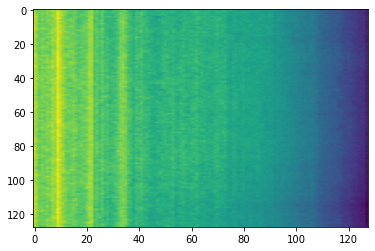

2020-11-05 00:21:28,472 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:16.608489, valid_AUC:0.489640, valid_pAUC:0.489815
100%|██████████| 1803/1803 [00:31<00:00, 57.82it/s]
2020-11-05 00:22:39,303 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:15.462047, valid_AUC:0.469321, valid_pAUC:0.488333
100%|██████████| 1803/1803 [00:30<00:00, 59.42it/s]
2020-11-05 00:23:48,641 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:15.461722, valid_AUC:0.512518, valid_pAUC:0.502523
100%|██████████| 1803/1803 [00:30<00:00, 59.64it/s]
2020-11-05 00:24:57,922 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:16.360674, valid_AUC:0.484752, valid_pAUC:0.501463
100%|██████████| 1803/1803 [00:30<00:00, 58.97it/s]
2020-11-05 00:26:06,605 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:16.697710, valid_AUC:0.538571, valid_pAUC:0.515849
100%|██████████| 1803/1803 [00:29<00:00, 60.18it/s]
2020-11-05 00:27:15,568 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:15.455942, valid_

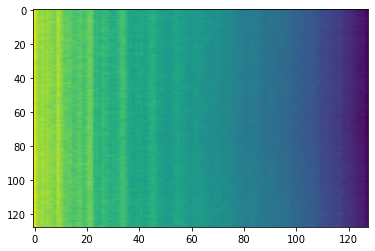

2020-11-05 00:32:59,754 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:15.012268, valid_AUC:0.460506, valid_pAUC:0.511685
100%|██████████| 1803/1803 [00:29<00:00, 60.33it/s]
2020-11-05 00:34:07,181 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:14.362207, valid_AUC:0.493795, valid_pAUC:0.506162
100%|██████████| 1803/1803 [00:29<00:00, 60.56it/s]
2020-11-05 00:35:14,457 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:13.729115, valid_AUC:0.515333, valid_pAUC:0.507850
100%|██████████| 1803/1803 [00:29<00:00, 60.15it/s]
2020-11-05 00:36:22,355 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:14.238791, valid_AUC:0.501823, valid_pAUC:0.502382
100%|██████████| 1803/1803 [00:29<00:00, 60.53it/s]
2020-11-05 00:37:29,853 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:14.662465, valid_AUC:0.467124, valid_pAUC:0.491184
100%|██████████| 1803/1803 [00:29<00:00, 60.58it/s]
2020-11-05 00:38:37,407 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:13.686941, valid_

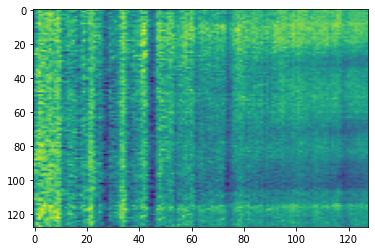

2020-11-05 00:44:14,901 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:14.334902, valid_AUC:0.507379, valid_pAUC:0.503892
100%|██████████| 1803/1803 [00:29<00:00, 60.88it/s]
2020-11-05 00:45:22,516 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:15.264083, valid_AUC:0.504551, valid_pAUC:0.497346
100%|██████████| 1803/1803 [00:29<00:00, 60.42it/s]
2020-11-05 00:46:29,896 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:14.947532, valid_AUC:0.508991, valid_pAUC:0.503770
100%|██████████| 1803/1803 [00:29<00:00, 61.22it/s]
2020-11-05 00:47:37,531 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:14.191452, valid_AUC:0.489157, valid_pAUC:0.503142
100%|██████████| 1803/1803 [00:29<00:00, 60.66it/s]
2020-11-05 00:48:45,084 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:13.753392, valid_AUC:0.509574, valid_pAUC:0.503442
100%|██████████| 1803/1803 [00:29<00:00, 60.58it/s]
2020-11-05 00:49:52,315 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:13.703964, valid_

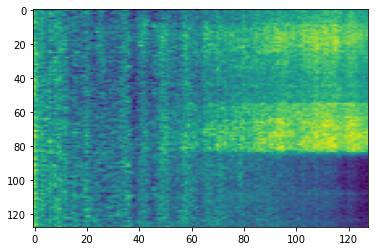

2020-11-05 00:55:30,146 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:12.154810, valid_AUC:0.512179, valid_pAUC:0.501266
100%|██████████| 1803/1803 [00:29<00:00, 60.37it/s]
2020-11-05 00:56:37,802 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:12.089412, valid_AUC:0.543861, valid_pAUC:0.506143
100%|██████████| 1803/1803 [00:29<00:00, 61.09it/s]
2020-11-05 00:57:45,162 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:11.987481, valid_AUC:0.489230, valid_pAUC:0.483363
100%|██████████| 1803/1803 [00:29<00:00, 61.15it/s]
2020-11-05 00:58:52,622 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:11.891201, valid_AUC:0.497129, valid_pAUC:0.510194
100%|██████████| 1803/1803 [00:29<00:00, 60.72it/s]
2020-11-05 01:00:00,347 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:13.092727, valid_AUC:0.487833, valid_pAUC:0.500741
100%|██████████| 1803/1803 [00:29<00:00, 60.87it/s]
2020-11-05 01:01:07,773 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:12.525974, valid_

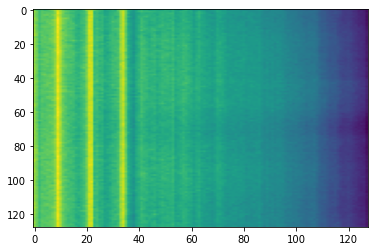

2020-11-05 01:06:51,257 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:11.844189, valid_AUC:0.533703, valid_pAUC:0.501097
100%|██████████| 1803/1803 [00:30<00:00, 58.56it/s]
2020-11-05 01:08:14,791 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:11.687637, valid_AUC:0.555404, valid_pAUC:0.517603
100%|██████████| 1803/1803 [00:30<00:00, 59.32it/s]
2020-11-05 01:09:23,610 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:11.525801, valid_AUC:0.565645, valid_pAUC:0.507362
100%|██████████| 1803/1803 [00:30<00:00, 58.55it/s]
2020-11-05 01:10:32,749 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:11.500644, valid_AUC:0.556397, valid_pAUC:0.503076
100%|██████████| 1803/1803 [00:30<00:00, 59.12it/s]
2020-11-05 01:11:43,133 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:11.615504, valid_AUC:0.502616, valid_pAUC:0.493688
100%|██████████| 1803/1803 [00:30<00:00, 58.93it/s]
2020-11-05 01:12:53,601 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:11.713688, valid_

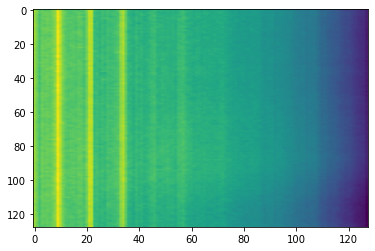

2020-11-05 01:18:43,146 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:11.502915, valid_AUC:0.556853, valid_pAUC:0.519516
100%|██████████| 1803/1803 [00:30<00:00, 59.58it/s]
2020-11-05 01:19:51,774 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:11.427098, valid_AUC:0.563789, valid_pAUC:0.506415
100%|██████████| 1803/1803 [00:30<00:00, 59.51it/s]
2020-11-05 01:21:01,646 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:11.418955, valid_AUC:0.548632, valid_pAUC:0.500713
100%|██████████| 1803/1803 [00:30<00:00, 59.81it/s]
2020-11-05 01:22:10,549 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:11.629773, valid_AUC:0.524213, valid_pAUC:0.506209
100%|██████████| 1803/1803 [00:30<00:00, 59.83it/s]
2020-11-05 01:23:18,739 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:11.414716, valid_AUC:0.560862, valid_pAUC:0.493735
100%|██████████| 1803/1803 [00:30<00:00, 59.47it/s]
2020-11-05 01:24:27,250 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:11.413124, valid_

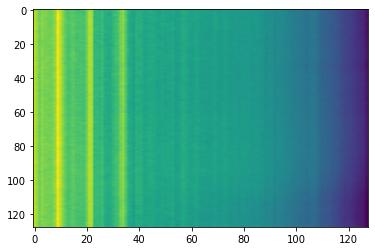

2020-11-05 01:30:08,135 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:11.515411, valid_AUC:0.558449, valid_pAUC:0.507306
100%|██████████| 1803/1803 [00:29<00:00, 60.93it/s]
2020-11-05 01:31:15,648 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:11.868972, valid_AUC:0.541377, valid_pAUC:0.509003
100%|██████████| 1803/1803 [00:29<00:00, 60.52it/s]
2020-11-05 01:32:23,327 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:11.505754, valid_AUC:0.541244, valid_pAUC:0.501304
100%|██████████| 1803/1803 [00:29<00:00, 60.69it/s]
2020-11-05 01:33:31,268 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:11.557385, valid_AUC:0.508569, valid_pAUC:0.483522
100%|██████████| 1803/1803 [00:29<00:00, 61.18it/s]
2020-11-05 01:34:38,928 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:11.301750, valid_AUC:0.524574, valid_pAUC:0.507503
100%|██████████| 1803/1803 [00:29<00:00, 60.63it/s]
2020-11-05 01:35:46,387 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:12.081380, valid_

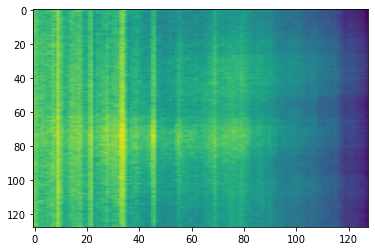

2020-11-05 01:41:26,181 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:11.310641, valid_AUC:0.521973, valid_pAUC:0.494082
100%|██████████| 1803/1803 [00:29<00:00, 60.56it/s]
2020-11-05 01:42:34,017 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:11.210177, valid_AUC:0.540175, valid_pAUC:0.501013
100%|██████████| 1803/1803 [00:29<00:00, 60.52it/s]
2020-11-05 01:43:41,661 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:11.238186, valid_AUC:0.581830, valid_pAUC:0.514874
100%|██████████| 1803/1803 [00:29<00:00, 60.52it/s]
2020-11-05 01:44:49,641 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:11.184173, valid_AUC:0.556850, valid_pAUC:0.495986
100%|██████████| 1803/1803 [00:29<00:00, 60.14it/s]
2020-11-05 01:45:57,634 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:11.238674, valid_AUC:0.547429, valid_pAUC:0.504530
100%|██████████| 1803/1803 [00:29<00:00, 60.39it/s]
2020-11-05 01:47:05,521 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:11.261366, valid_

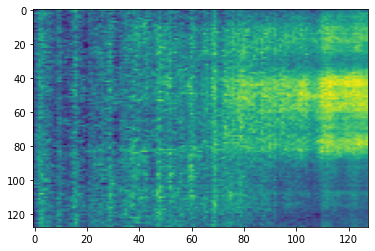

2020-11-05 01:52:45,766 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:11.704425, valid_AUC:0.525804, valid_pAUC:0.495639
100%|██████████| 1803/1803 [00:29<00:00, 60.33it/s]
2020-11-05 01:53:53,667 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:11.468909, valid_AUC:0.507471, valid_pAUC:0.493538
100%|██████████| 1803/1803 [00:29<00:00, 60.67it/s]
2020-11-05 01:55:01,328 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:12.140136, valid_AUC:0.538247, valid_pAUC:0.505468
100%|██████████| 1803/1803 [00:30<00:00, 60.04it/s]
2020-11-05 01:56:09,750 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:12.235499, valid_AUC:0.537452, valid_pAUC:0.507465
100%|██████████| 1803/1803 [00:28<00:00, 63.32it/s] 
2020-11-05 01:57:16,231 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:11.738749, valid_AUC:0.500262, valid_pAUC:0.494626
100%|██████████| 1803/1803 [00:29<00:00, 60.63it/s]
2020-11-05 01:58:24,038 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:11.704377, valid

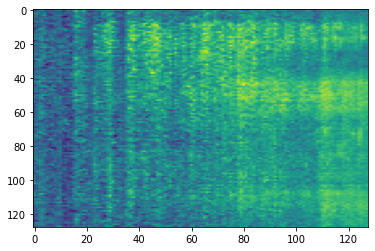

2020-11-05 02:04:03,145 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:11.300548, valid_AUC:0.530895, valid_pAUC:0.502795
2020-11-05 02:04:04,248 - 00_train.py - INFO - 
 success:fan 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM3_CONV2_AE/models/fan_model.pth


elapsed time: 6883.171175480 [sec]


2020-11-05 02:04:05,259 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2020-11-05 02:04:05,260 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-05 02:04:05,262 - 00_train.py - INFO - TRAINING
  0%|          | 0/181 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 832/832 [00:13<00:00, 60.68it/s]


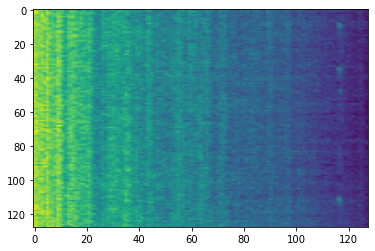

2020-11-05 02:04:52,588 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:85.103154, valid_AUC:0.518576, valid_pAUC:0.489431
100%|██████████| 832/832 [00:13<00:00, 60.21it/s]
2020-11-05 02:05:39,352 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:30.184339, valid_AUC:0.508519, valid_pAUC:0.487208
100%|██████████| 832/832 [00:13<00:00, 60.65it/s]
2020-11-05 02:06:26,372 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:24.778986, valid_AUC:0.337500, valid_pAUC:0.486081
100%|██████████| 832/832 [00:13<00:00, 60.66it/s]
2020-11-05 02:07:13,498 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:21.501935, valid_AUC:0.339641, valid_pAUC:0.495340
100%|██████████| 832/832 [00:13<00:00, 60.30it/s]
2020-11-05 02:08:00,913 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:20.258637, valid_AUC:0.432685, valid_pAUC:0.493056
100%|██████████| 832/832 [00:13<00:00, 60.61it/s]
2020-11-05 02:08:48,356 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:19.224320, valid_AUC:0.546209, va

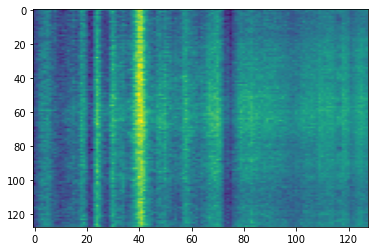

2020-11-05 02:11:58,360 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:16.907791, valid_AUC:0.575081, valid_pAUC:0.503899
100%|██████████| 832/832 [00:13<00:00, 61.28it/s]
2020-11-05 02:12:45,962 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:16.284639, valid_AUC:0.630532, valid_pAUC:0.497320
100%|██████████| 832/832 [00:13<00:00, 61.27it/s]
2020-11-05 02:13:33,755 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:16.231835, valid_AUC:0.371840, valid_pAUC:0.487238
100%|██████████| 832/832 [00:13<00:00, 60.57it/s]
2020-11-05 02:14:21,843 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:17.775368, valid_AUC:0.422002, valid_pAUC:0.494152
100%|██████████| 832/832 [00:13<00:00, 61.30it/s]
2020-11-05 02:15:09,525 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:17.600185, valid_AUC:0.429737, valid_pAUC:0.490649
100%|██████████| 832/832 [00:13<00:00, 60.19it/s]
2020-11-05 02:15:57,680 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:17.754638, valid_AUC:0.3451

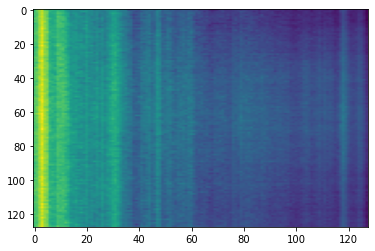

2020-11-05 02:19:57,669 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:14.635312, valid_AUC:0.607755, valid_pAUC:0.477491
100%|██████████| 832/832 [00:13<00:00, 60.75it/s]
2020-11-05 02:20:45,310 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:14.441750, valid_AUC:0.602512, valid_pAUC:0.484070
100%|██████████| 832/832 [00:13<00:00, 60.97it/s]
2020-11-05 02:21:32,819 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:14.352310, valid_AUC:0.624138, valid_pAUC:0.504020
100%|██████████| 832/832 [00:13<00:00, 59.82it/s]
2020-11-05 02:22:20,891 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:14.239001, valid_AUC:0.620689, valid_pAUC:0.494609
100%|██████████| 832/832 [00:13<00:00, 59.49it/s]
2020-11-05 02:23:08,480 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:15.103963, valid_AUC:0.651435, valid_pAUC:0.520255
100%|██████████| 832/832 [00:13<00:00, 60.24it/s]
2020-11-05 02:23:55,743 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:14.755694, valid_AUC:0.5441

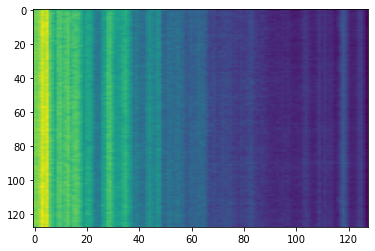

2020-11-05 02:27:52,216 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:13.763885, valid_AUC:0.648773, valid_pAUC:0.494061
100%|██████████| 832/832 [00:13<00:00, 59.66it/s]
2020-11-05 02:28:39,435 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:13.547674, valid_AUC:0.602101, valid_pAUC:0.510051
100%|██████████| 832/832 [00:13<00:00, 60.16it/s]
2020-11-05 02:29:26,399 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:13.406970, valid_AUC:0.615289, valid_pAUC:0.495218
100%|██████████| 832/832 [00:14<00:00, 59.07it/s]
2020-11-05 02:30:13,927 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:13.226326, valid_AUC:0.635689, valid_pAUC:0.506092
100%|██████████| 832/832 [00:13<00:00, 60.01it/s]
2020-11-05 02:31:01,220 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:13.197005, valid_AUC:0.657899, valid_pAUC:0.499299
100%|██████████| 832/832 [00:13<00:00, 59.87it/s]
2020-11-05 02:31:48,444 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:13.129364, valid_AUC:0.5882

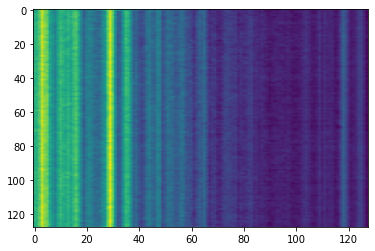

2020-11-05 02:35:46,439 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:13.022523, valid_AUC:0.565492, valid_pAUC:0.509899
100%|██████████| 832/832 [00:13<00:00, 59.99it/s]
2020-11-05 02:36:34,544 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:13.375157, valid_AUC:0.710457, valid_pAUC:0.541027
100%|██████████| 832/832 [00:13<00:00, 60.84it/s]
2020-11-05 02:37:22,371 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:13.086174, valid_AUC:0.645104, valid_pAUC:0.504782
100%|██████████| 832/832 [00:14<00:00, 59.35it/s]
2020-11-05 02:38:10,420 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:13.603274, valid_AUC:0.681794, valid_pAUC:0.503168
100%|██████████| 832/832 [00:13<00:00, 60.38it/s]
2020-11-05 02:38:58,495 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:13.057750, valid_AUC:0.720608, valid_pAUC:0.576663
100%|██████████| 832/832 [00:13<00:00, 60.26it/s]
2020-11-05 02:39:46,604 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:12.833860, valid_AUC:0.6728

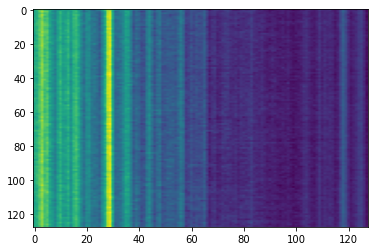

2020-11-05 02:43:46,708 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:12.852472, valid_AUC:0.677639, valid_pAUC:0.559972
100%|██████████| 832/832 [00:13<00:00, 60.81it/s]
2020-11-05 02:44:34,614 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:12.575538, valid_AUC:0.696105, valid_pAUC:0.577211
100%|██████████| 832/832 [00:13<00:00, 60.98it/s]
2020-11-05 02:45:22,154 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:12.489402, valid_AUC:0.682176, valid_pAUC:0.568013
100%|██████████| 832/832 [00:13<00:00, 59.90it/s]
2020-11-05 02:46:09,762 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:12.475800, valid_AUC:0.700203, valid_pAUC:0.578521
100%|██████████| 832/832 [00:13<00:00, 60.67it/s]
2020-11-05 02:46:57,262 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:12.437844, valid_AUC:0.717274, valid_pAUC:0.618726
100%|██████████| 832/832 [00:13<00:00, 60.80it/s]
2020-11-05 02:47:44,545 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:12.285607, valid_AUC:0.7130

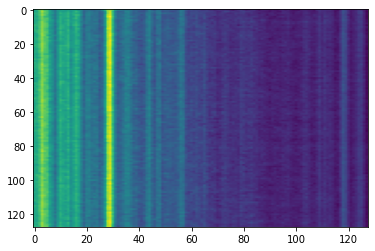

2020-11-05 02:51:40,224 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:12.840348, valid_AUC:0.706152, valid_pAUC:0.556652
100%|██████████| 832/832 [00:13<00:00, 60.41it/s]
2020-11-05 02:52:27,252 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:12.600968, valid_AUC:0.673333, valid_pAUC:0.539565
100%|██████████| 832/832 [00:13<00:00, 60.61it/s]
2020-11-05 02:53:14,107 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:12.375603, valid_AUC:0.705000, valid_pAUC:0.612664
100%|██████████| 832/832 [00:13<00:00, 59.55it/s]
2020-11-05 02:54:01,264 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:12.328422, valid_AUC:0.705608, valid_pAUC:0.590826
100%|██████████| 832/832 [00:13<00:00, 59.97it/s]
2020-11-05 02:54:48,668 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:12.365378, valid_AUC:0.697251, valid_pAUC:0.562561
100%|██████████| 832/832 [00:13<00:00, 60.45it/s]
2020-11-05 02:55:35,652 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:12.145273, valid_AUC:0.7029

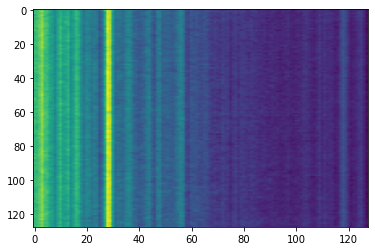

2020-11-05 02:59:32,279 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:12.317849, valid_AUC:0.684867, valid_pAUC:0.549342
100%|██████████| 832/832 [00:13<00:00, 60.34it/s]
2020-11-05 03:00:19,905 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:12.096614, valid_AUC:0.682772, valid_pAUC:0.556713
100%|██████████| 832/832 [00:13<00:00, 60.40it/s]
2020-11-05 03:01:07,612 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:12.095177, valid_AUC:0.688623, valid_pAUC:0.592989
100%|██████████| 832/832 [00:13<00:00, 60.69it/s]
2020-11-05 03:01:55,382 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:12.185905, valid_AUC:0.686997, valid_pAUC:0.540479
100%|██████████| 832/832 [00:13<00:00, 62.16it/s]
2020-11-05 03:02:43,103 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:12.131469, valid_AUC:0.689688, valid_pAUC:0.556896
100%|██████████| 832/832 [00:13<00:00, 60.69it/s]
2020-11-05 03:03:31,066 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:12.176656, valid_AUC:0.6742

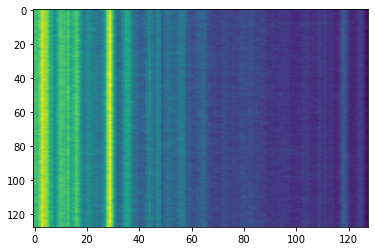

2020-11-05 03:07:30,649 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:12.004942, valid_AUC:0.682778, valid_pAUC:0.572673
100%|██████████| 832/832 [00:13<00:00, 60.76it/s]
2020-11-05 03:08:18,797 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:12.104514, valid_AUC:0.698380, valid_pAUC:0.588359
100%|██████████| 832/832 [00:13<00:00, 60.14it/s]
2020-11-05 03:09:06,990 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:11.912290, valid_AUC:0.702054, valid_pAUC:0.582572
100%|██████████| 832/832 [00:13<00:00, 60.61it/s]
2020-11-05 03:09:54,823 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:12.288993, valid_AUC:0.672836, valid_pAUC:0.521503
100%|██████████| 832/832 [00:13<00:00, 60.87it/s]
2020-11-05 03:10:42,701 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:12.248626, valid_AUC:0.708553, valid_pAUC:0.580166
100%|██████████| 832/832 [00:13<00:00, 60.66it/s]
2020-11-05 03:11:30,438 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:12.146386, valid_AUC:0.6968

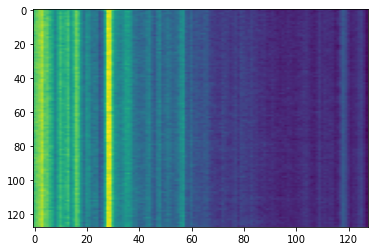

2020-11-05 03:15:54,668 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:11.905500, valid_AUC:0.710509, valid_pAUC:0.612086
100%|██████████| 832/832 [00:13<00:00, 60.58it/s]
2020-11-05 03:16:39,354 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:12.029403, valid_AUC:0.682506, valid_pAUC:0.575932
100%|██████████| 832/832 [00:13<00:00, 61.12it/s]
2020-11-05 03:17:27,699 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:11.883765, valid_AUC:0.698368, valid_pAUC:0.597527
100%|██████████| 832/832 [00:13<00:00, 60.32it/s]
2020-11-05 03:18:16,353 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:11.924763, valid_AUC:0.694687, valid_pAUC:0.576267
100%|██████████| 832/832 [00:13<00:00, 60.73it/s]
2020-11-05 03:19:04,796 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:11.839817, valid_AUC:0.686872, valid_pAUC:0.578216
100%|██████████| 832/832 [00:13<00:00, 60.37it/s]
2020-11-05 03:19:53,470 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:12.405157, valid_AUC:0.7097

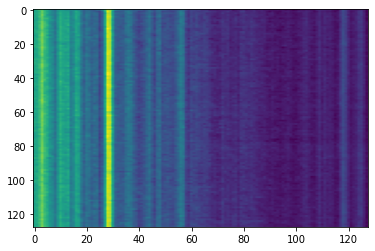

2020-11-05 03:23:56,292 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:12.007781, valid_AUC:0.683374, valid_pAUC:0.550895
2020-11-05 03:23:57,091 - 00_train.py - INFO - 
 success:pump 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM3_CONV2_AE/models/pump_model.pth


elapsed time: 4791.833428383 [sec]


2020-11-05 03:23:58,378 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2020-11-05 03:23:58,380 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-05 03:23:58,382 - 00_train.py - INFO - TRAINING
  0%|          | 0/162 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 1246/1246 [00:20<00:00, 61.09it/s]


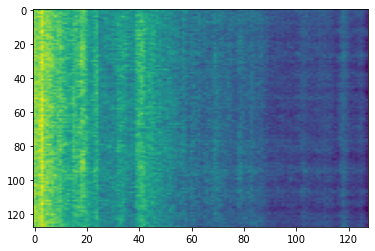

2020-11-05 03:24:52,952 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:67.844322, valid_AUC:0.748913, valid_pAUC:0.589104
100%|██████████| 1246/1246 [00:20<00:00, 60.31it/s]
2020-11-05 03:25:44,465 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:32.648952, valid_AUC:0.660662, valid_pAUC:0.516564
100%|██████████| 1246/1246 [00:20<00:00, 60.72it/s]
2020-11-05 03:26:35,977 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:24.376032, valid_AUC:0.564619, valid_pAUC:0.480341
100%|██████████| 1246/1246 [00:20<00:00, 60.60it/s]
2020-11-05 03:27:27,716 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:22.995890, valid_AUC:0.670139, valid_pAUC:0.562601
100%|██████████| 1246/1246 [00:20<00:00, 60.30it/s]
2020-11-05 03:28:19,665 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:22.011871, valid_AUC:0.620789, valid_pAUC:0.502908
100%|██████████| 1246/1246 [00:20<00:00, 60.66it/s]
2020-11-05 03:29:11,431 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:24.374817, valid_AUC:0.

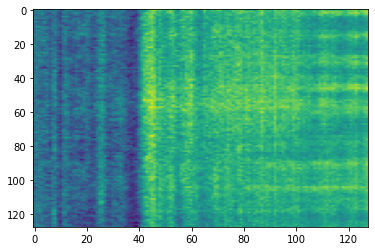

2020-11-05 03:32:39,780 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:22.773515, valid_AUC:0.230021, valid_pAUC:0.478381
100%|██████████| 1246/1246 [00:20<00:00, 61.11it/s]
2020-11-05 03:33:31,673 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:21.508796, valid_AUC:0.483230, valid_pAUC:0.478910
100%|██████████| 1246/1246 [00:20<00:00, 60.68it/s]
2020-11-05 03:34:23,837 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:20.148993, valid_AUC:0.282274, valid_pAUC:0.478024
100%|██████████| 1246/1246 [00:20<00:00, 60.97it/s]
2020-11-05 03:35:15,755 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:20.965617, valid_AUC:0.646291, valid_pAUC:0.490170
100%|██████████| 1246/1246 [00:20<00:00, 60.07it/s]
2020-11-05 03:36:08,005 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:20.177421, valid_AUC:0.452293, valid_pAUC:0.477666
100%|██████████| 1246/1246 [00:20<00:00, 59.93it/s]
2020-11-05 03:37:00,256 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:18.677341, valid_

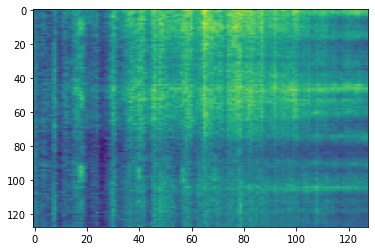

2020-11-05 03:41:18,722 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:16.525515, valid_AUC:0.336661, valid_pAUC:0.477417
100%|██████████| 1246/1246 [00:20<00:00, 59.80it/s]
2020-11-05 03:42:10,497 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:16.433899, valid_AUC:0.598632, valid_pAUC:0.512116
100%|██████████| 1246/1246 [00:20<00:00, 59.93it/s]
2020-11-05 03:43:02,179 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:15.871160, valid_AUC:0.333454, valid_pAUC:0.479672
100%|██████████| 1246/1246 [00:20<00:00, 60.15it/s]
2020-11-05 03:43:53,299 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:15.449828, valid_AUC:0.383593, valid_pAUC:0.484696
100%|██████████| 1246/1246 [00:20<00:00, 59.77it/s]
2020-11-05 03:44:44,894 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:15.279921, valid_AUC:0.312367, valid_pAUC:0.477495
100%|██████████| 1246/1246 [00:20<00:00, 60.59it/s]
2020-11-05 03:45:35,800 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:18.177181, valid_

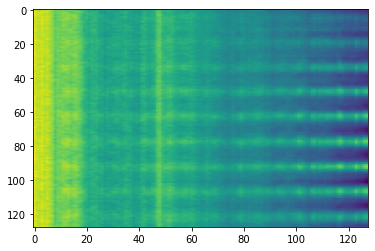

2020-11-05 03:49:51,789 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:14.732663, valid_AUC:0.741528, valid_pAUC:0.528135
100%|██████████| 1246/1246 [00:20<00:00, 59.57it/s]
2020-11-05 03:50:43,147 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:14.714649, valid_AUC:0.734704, valid_pAUC:0.491119
100%|██████████| 1246/1246 [00:20<00:00, 60.02it/s]
2020-11-05 03:51:33,989 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:14.488797, valid_AUC:0.617592, valid_pAUC:0.477961
100%|██████████| 1246/1246 [00:20<00:00, 60.14it/s]
2020-11-05 03:52:24,964 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:14.496974, valid_AUC:0.654613, valid_pAUC:0.527451
100%|██████████| 1246/1246 [00:20<00:00, 59.97it/s]
2020-11-05 03:53:15,764 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:14.908024, valid_AUC:0.657024, valid_pAUC:0.507357
100%|██████████| 1246/1246 [00:20<00:00, 59.39it/s]
2020-11-05 03:54:06,795 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:14.510182, valid_

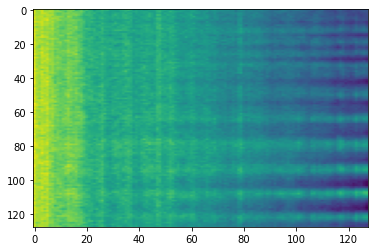

2020-11-05 03:58:21,079 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:14.110849, valid_AUC:0.513667, valid_pAUC:0.484867
100%|██████████| 1246/1246 [00:20<00:00, 59.44it/s]
2020-11-05 03:59:11,911 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:14.391187, valid_AUC:0.247500, valid_pAUC:0.478117
100%|██████████| 1246/1246 [00:21<00:00, 59.07it/s]
2020-11-05 04:00:02,714 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:13.949407, valid_AUC:0.761856, valid_pAUC:0.583147
100%|██████████| 1246/1246 [00:20<00:00, 59.52it/s]
2020-11-05 04:00:53,684 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:13.775930, valid_AUC:0.757716, valid_pAUC:0.552445
100%|██████████| 1246/1246 [00:20<00:00, 60.24it/s]
2020-11-05 04:01:44,359 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:13.797052, valid_AUC:0.769967, valid_pAUC:0.596336
100%|██████████| 1246/1246 [00:20<00:00, 60.10it/s]
2020-11-05 04:02:35,200 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:13.832138, valid_

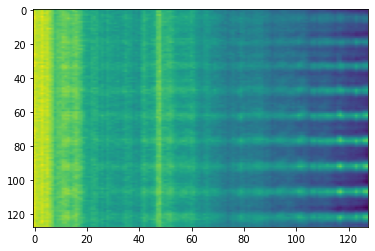

2020-11-05 04:06:50,549 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:13.460502, valid_AUC:0.672066, valid_pAUC:0.485551
100%|██████████| 1246/1246 [00:20<00:00, 60.23it/s]
2020-11-05 04:07:41,260 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:13.404921, valid_AUC:0.595165, valid_pAUC:0.485862
100%|██████████| 1246/1246 [00:20<00:00, 59.68it/s]
2020-11-05 04:08:32,699 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:13.299987, valid_AUC:0.615000, valid_pAUC:0.483934
100%|██████████| 1246/1246 [00:20<00:00, 59.40it/s]
2020-11-05 04:09:24,034 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:13.575693, valid_AUC:0.439625, valid_pAUC:0.481087
100%|██████████| 1246/1246 [00:21<00:00, 58.99it/s]
2020-11-05 04:10:15,866 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:13.229949, valid_AUC:0.421566, valid_pAUC:0.485676
100%|██████████| 1246/1246 [00:20<00:00, 59.78it/s]
2020-11-05 04:11:07,381 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:13.276071, valid_

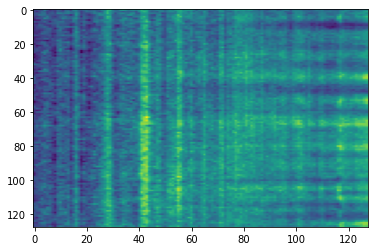

2020-11-05 04:15:24,332 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:13.213094, valid_AUC:0.474214, valid_pAUC:0.517419
100%|██████████| 1246/1246 [00:20<00:00, 60.89it/s]
2020-11-05 04:16:15,768 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:13.037776, valid_AUC:0.396625, valid_pAUC:0.478599
100%|██████████| 1246/1246 [00:20<00:00, 61.40it/s]
2020-11-05 04:17:07,204 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:13.177946, valid_AUC:0.320683, valid_pAUC:0.478879
100%|██████████| 1246/1246 [00:20<00:00, 60.64it/s]
2020-11-05 04:17:58,958 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:17.398070, valid_AUC:0.757722, valid_pAUC:0.572446
100%|██████████| 1246/1246 [00:20<00:00, 61.10it/s]
2020-11-05 04:18:50,846 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:19.589625, valid_AUC:0.299660, valid_pAUC:0.480621
100%|██████████| 1246/1246 [00:20<00:00, 61.31it/s]
2020-11-05 04:19:42,280 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:18.893030, valid_

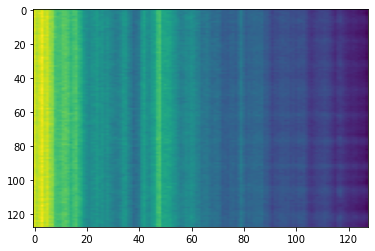

2020-11-05 04:24:01,667 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:16.616396, valid_AUC:0.696407, valid_pAUC:0.531884
100%|██████████| 1246/1246 [00:20<00:00, 61.49it/s]
2020-11-05 04:24:53,200 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:16.287407, valid_AUC:0.686587, valid_pAUC:0.529893
100%|██████████| 1246/1246 [00:20<00:00, 61.20it/s]
2020-11-05 04:25:45,032 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:16.080685, valid_AUC:0.677852, valid_pAUC:0.529022
100%|██████████| 1246/1246 [00:20<00:00, 61.18it/s]
2020-11-05 04:26:36,497 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:16.021565, valid_AUC:0.678579, valid_pAUC:0.520763
100%|██████████| 1246/1246 [00:20<00:00, 61.28it/s]
2020-11-05 04:27:27,951 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:15.903354, valid_AUC:0.687077, valid_pAUC:0.522739
100%|██████████| 1246/1246 [00:20<00:00, 60.40it/s]
2020-11-05 04:28:19,841 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:15.830378, valid_

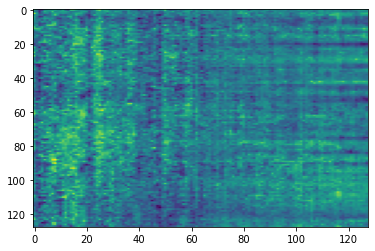

2020-11-05 04:32:36,972 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:15.676451, valid_AUC:0.532506, valid_pAUC:0.492099
100%|██████████| 1246/1246 [00:20<00:00, 60.71it/s]
2020-11-05 04:33:28,218 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:15.538323, valid_AUC:0.712349, valid_pAUC:0.530982
100%|██████████| 1246/1246 [00:20<00:00, 59.89it/s]
2020-11-05 04:34:19,922 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:15.364728, valid_AUC:0.682991, valid_pAUC:0.505661
100%|██████████| 1246/1246 [00:20<00:00, 60.61it/s]
2020-11-05 04:35:10,910 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:15.453597, valid_AUC:0.692204, valid_pAUC:0.542429
100%|██████████| 1246/1246 [00:20<00:00, 60.19it/s]
2020-11-05 04:36:02,094 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:15.278292, valid_AUC:0.656888, valid_pAUC:0.497869
100%|██████████| 1246/1246 [00:20<00:00, 60.43it/s]
2020-11-05 04:36:53,196 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:15.158987, valid_

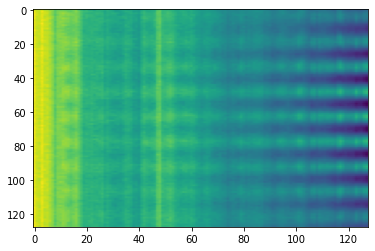

2020-11-05 04:41:22,407 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:15.145902, valid_AUC:0.675700, valid_pAUC:0.496267
100%|██████████| 1246/1246 [00:20<00:00, 60.53it/s]
2020-11-05 04:42:12,924 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:14.894700, valid_AUC:0.717881, valid_pAUC:0.533610
100%|██████████| 1246/1246 [00:20<00:00, 60.72it/s]
2020-11-05 04:43:03,504 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:15.016489, valid_AUC:0.709444, valid_pAUC:0.529318
100%|██████████| 1246/1246 [00:20<00:00, 61.24it/s]
2020-11-05 04:43:53,757 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:14.970191, valid_AUC:0.582139, valid_pAUC:0.491679
100%|██████████| 1246/1246 [00:20<00:00, 60.39it/s]
2020-11-05 04:44:44,694 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:14.850510, valid_AUC:0.737875, valid_pAUC:0.550532
100%|██████████| 1246/1246 [00:20<00:00, 61.75it/s]
2020-11-05 04:45:35,080 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:14.703218, valid_

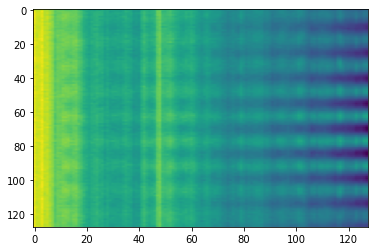

2020-11-05 04:49:47,575 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:14.734739, valid_AUC:0.679010, valid_pAUC:0.496718
2020-11-05 04:49:48,473 - 00_train.py - INFO - 
 success:slider 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM3_CONV2_AE/models/slider_model.pth


elapsed time: 5150.100938797 [sec]


2020-11-05 04:49:51,721 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2020-11-05 04:49:51,722 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-05 04:49:51,726 - 00_train.py - INFO - TRAINING
  0%|          | 0/219 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 2407/2407 [00:39<00:00, 61.64it/s]


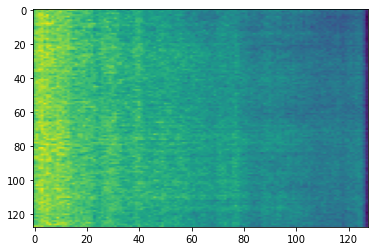

2020-11-05 04:51:13,554 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:67.696049, valid_AUC:0.400386, valid_pAUC:0.486351
100%|██████████| 2407/2407 [00:38<00:00, 61.82it/s]
2020-11-05 04:52:33,224 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:25.500492, valid_AUC:0.513987, valid_pAUC:0.526316
100%|██████████| 2407/2407 [00:39<00:00, 61.59it/s]
2020-11-05 04:53:52,701 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:21.135823, valid_AUC:0.625996, valid_pAUC:0.526629
100%|██████████| 2407/2407 [00:38<00:00, 62.59it/s]
2020-11-05 04:55:11,963 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:17.638503, valid_AUC:0.488867, valid_pAUC:0.506253
100%|██████████| 2407/2407 [00:39<00:00, 61.21it/s]
2020-11-05 04:56:32,595 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:16.983309, valid_AUC:0.612312, valid_pAUC:0.526693
100%|██████████| 2407/2407 [00:39<00:00, 61.68it/s]
2020-11-05 04:57:52,569 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:16.131858, valid_AUC:0.

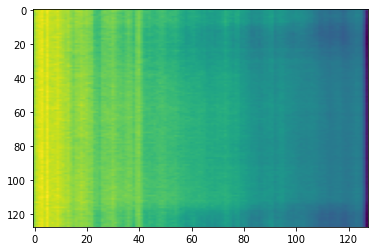

2020-11-05 05:03:12,502 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:14.707688, valid_AUC:0.657827, valid_pAUC:0.535291
100%|██████████| 2407/2407 [00:39<00:00, 61.38it/s]
2020-11-05 05:04:32,381 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:16.158415, valid_AUC:0.589453, valid_pAUC:0.514616
100%|██████████| 2407/2407 [00:39<00:00, 61.57it/s]
2020-11-05 05:05:52,283 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:15.198828, valid_AUC:0.658774, valid_pAUC:0.530225
100%|██████████| 2407/2407 [00:38<00:00, 61.97it/s]
2020-11-05 05:07:12,069 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:14.268924, valid_AUC:0.674375, valid_pAUC:0.525200
100%|██████████| 2407/2407 [00:38<00:00, 61.72it/s]
2020-11-05 05:08:32,107 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:14.754071, valid_AUC:0.653380, valid_pAUC:0.522844
100%|██████████| 2407/2407 [00:38<00:00, 62.03it/s]
2020-11-05 05:09:51,517 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:14.989284, valid_

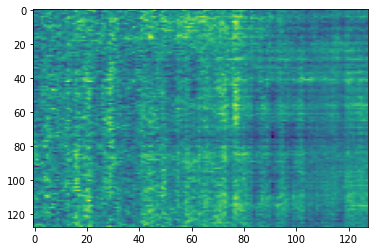

2020-11-05 05:16:29,801 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:13.834886, valid_AUC:0.418953, valid_pAUC:0.497144
100%|██████████| 2407/2407 [00:38<00:00, 62.56it/s]
2020-11-05 05:17:48,737 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:13.574947, valid_AUC:0.672792, valid_pAUC:0.535921
100%|██████████| 2407/2407 [00:38<00:00, 61.83it/s]
2020-11-05 05:19:09,083 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:13.473888, valid_AUC:0.533596, valid_pAUC:0.527634
100%|██████████| 2407/2407 [00:39<00:00, 61.03it/s]
2020-11-05 05:20:29,320 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:13.368911, valid_AUC:0.510894, valid_pAUC:0.500679
100%|██████████| 2407/2407 [00:39<00:00, 61.45it/s]
2020-11-05 05:21:49,165 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:12.885567, valid_AUC:0.686785, valid_pAUC:0.534133
100%|██████████| 2407/2407 [00:38<00:00, 62.35it/s]
2020-11-05 05:23:08,794 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:12.664275, valid_

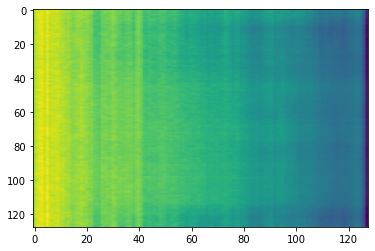

2020-11-05 05:29:16,282 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:11.873517, valid_AUC:0.616337, valid_pAUC:0.493956
100%|██████████| 2407/2407 [00:22<00:00, 108.48it/s]
2020-11-05 05:30:03,235 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:11.682779, valid_AUC:0.649003, valid_pAUC:0.531516
100%|██████████| 2407/2407 [00:21<00:00, 113.82it/s]
2020-11-05 05:30:49,244 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:11.589839, valid_AUC:0.502878, valid_pAUC:0.506388
100%|██████████| 2407/2407 [00:21<00:00, 113.84it/s]
2020-11-05 05:31:35,028 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:11.535650, valid_AUC:0.468217, valid_pAUC:0.515221
100%|██████████| 2407/2407 [00:21<00:00, 114.08it/s]
2020-11-05 05:32:20,991 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:13.953519, valid_AUC:0.491022, valid_pAUC:0.503823
100%|██████████| 2407/2407 [00:21<00:00, 113.02it/s]
2020-11-05 05:33:06,912 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:15.051792, v

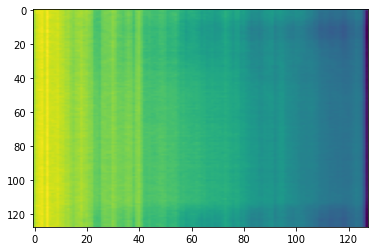

2020-11-05 05:36:56,551 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:13.236114, valid_AUC:0.645562, valid_pAUC:0.539599
100%|██████████| 2407/2407 [00:21<00:00, 113.88it/s]
2020-11-05 05:37:42,481 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:12.934476, valid_AUC:0.680160, valid_pAUC:0.536944
100%|██████████| 2407/2407 [00:21<00:00, 113.74it/s]
2020-11-05 05:38:28,521 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:12.677652, valid_AUC:0.645805, valid_pAUC:0.528250
100%|██████████| 2407/2407 [00:21<00:00, 113.44it/s]
2020-11-05 05:39:14,386 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:12.435981, valid_AUC:0.689468, valid_pAUC:0.550903
100%|██████████| 2407/2407 [00:21<00:00, 112.85it/s]
2020-11-05 05:40:00,351 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:12.182409, valid_AUC:0.650553, valid_pAUC:0.517177
100%|██████████| 2407/2407 [00:21<00:00, 113.71it/s]
2020-11-05 05:40:46,152 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:12.078395, v

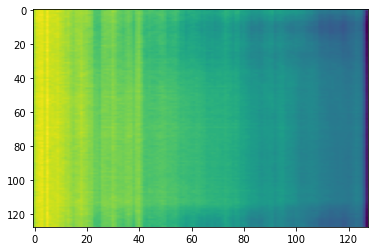

2020-11-05 05:44:35,425 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:11.415140, valid_AUC:0.678410, valid_pAUC:0.530146
100%|██████████| 2407/2407 [00:21<00:00, 114.04it/s]
2020-11-05 05:45:21,190 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:12.014384, valid_AUC:0.530272, valid_pAUC:0.513085
100%|██████████| 2407/2407 [00:21<00:00, 112.59it/s]
2020-11-05 05:46:07,168 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:12.498777, valid_AUC:0.510268, valid_pAUC:0.508041
100%|██████████| 2407/2407 [00:21<00:00, 113.96it/s]
2020-11-05 05:46:53,023 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:11.892782, valid_AUC:0.645603, valid_pAUC:0.500915
100%|██████████| 2407/2407 [00:21<00:00, 113.99it/s]
2020-11-05 05:47:38,813 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:11.551265, valid_AUC:0.663102, valid_pAUC:0.537415
100%|██████████| 2407/2407 [00:21<00:00, 113.91it/s]
2020-11-05 05:48:24,604 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:11.462844, v

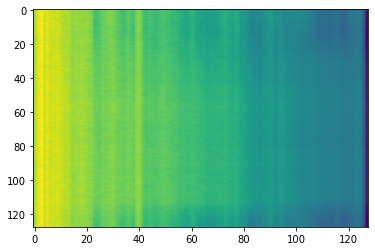

2020-11-05 05:52:14,057 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:14.323715, valid_AUC:0.672787, valid_pAUC:0.531729
100%|██████████| 2407/2407 [00:21<00:00, 113.96it/s]
2020-11-05 05:52:59,704 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:14.143798, valid_AUC:0.678313, valid_pAUC:0.537407
100%|██████████| 2407/2407 [00:21<00:00, 113.79it/s]
2020-11-05 05:53:45,559 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:13.712624, valid_AUC:0.566986, valid_pAUC:0.512443
100%|██████████| 2407/2407 [00:21<00:00, 114.04it/s]
2020-11-05 05:54:31,396 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:13.310312, valid_AUC:0.656765, valid_pAUC:0.525285
100%|██████████| 2407/2407 [00:21<00:00, 114.23it/s]
2020-11-05 05:55:17,073 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:12.765201, valid_AUC:0.663060, valid_pAUC:0.532707
100%|██████████| 2407/2407 [00:21<00:00, 113.12it/s]
2020-11-05 05:56:03,019 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:12.244412, v

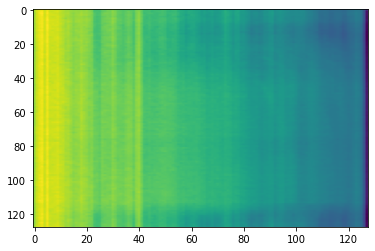

2020-11-05 05:59:52,396 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:11.460993, valid_AUC:0.638774, valid_pAUC:0.503972
100%|██████████| 2407/2407 [00:21<00:00, 113.90it/s]
2020-11-05 06:00:38,256 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:11.195404, valid_AUC:0.673031, valid_pAUC:0.546498
100%|██████████| 2407/2407 [00:21<00:00, 113.74it/s]
2020-11-05 06:01:24,117 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:11.168659, valid_AUC:0.678825, valid_pAUC:0.531512
100%|██████████| 2407/2407 [00:21<00:00, 112.88it/s]
2020-11-05 06:02:10,166 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:11.148335, valid_AUC:0.625179, valid_pAUC:0.513794
100%|██████████| 2407/2407 [00:21<00:00, 113.84it/s]
2020-11-05 06:02:55,954 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:11.155328, valid_AUC:0.449623, valid_pAUC:0.501422
100%|██████████| 2407/2407 [00:21<00:00, 113.69it/s]
2020-11-05 06:03:41,765 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:11.517452, v

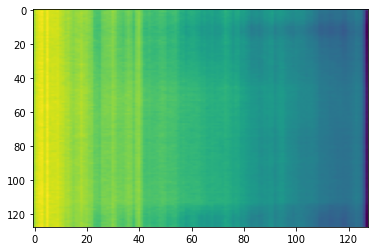

2020-11-05 06:07:31,651 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:10.957854, valid_AUC:0.667532, valid_pAUC:0.531990
100%|██████████| 2407/2407 [00:21<00:00, 113.67it/s]
2020-11-05 06:08:17,644 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:11.018745, valid_AUC:0.510198, valid_pAUC:0.512921
100%|██████████| 2407/2407 [00:21<00:00, 113.86it/s]
2020-11-05 06:09:03,416 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:10.910345, valid_AUC:0.660519, valid_pAUC:0.517065
100%|██████████| 2407/2407 [00:21<00:00, 112.80it/s]
2020-11-05 06:09:49,451 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:10.941360, valid_AUC:0.584036, valid_pAUC:0.504502
100%|██████████| 2407/2407 [00:21<00:00, 114.12it/s]
2020-11-05 06:10:35,222 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:10.868306, valid_AUC:0.647388, valid_pAUC:0.520611
100%|██████████| 2407/2407 [00:21<00:00, 113.98it/s]
2020-11-05 06:11:21,086 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:10.862404, v

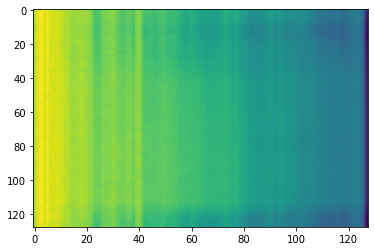

2020-11-05 06:15:10,787 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:11.177013, valid_AUC:0.623262, valid_pAUC:0.521799
100%|██████████| 2407/2407 [00:21<00:00, 112.84it/s]
2020-11-05 06:15:56,866 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:11.010197, valid_AUC:0.646669, valid_pAUC:0.530900
100%|██████████| 2407/2407 [00:21<00:00, 114.23it/s]
2020-11-05 06:16:42,638 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:10.992478, valid_AUC:0.603708, valid_pAUC:0.514313
100%|██████████| 2407/2407 [00:21<00:00, 113.90it/s]
2020-11-05 06:17:28,374 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:10.854837, valid_AUC:0.632053, valid_pAUC:0.505581
100%|██████████| 2407/2407 [00:21<00:00, 114.11it/s]
2020-11-05 06:18:14,347 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:10.853727, valid_AUC:0.637083, valid_pAUC:0.521911
100%|██████████| 2407/2407 [00:21<00:00, 114.13it/s]
2020-11-05 06:19:00,036 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:10.924533, v

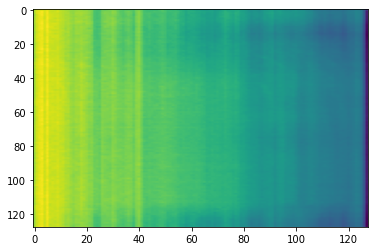

2020-11-05 06:22:50,061 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:10.855130, valid_AUC:0.673906, valid_pAUC:0.530277
2020-11-05 06:22:50,676 - 00_train.py - INFO - 
 success:ToyCar 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM3_CONV2_AE/models/ToyCar_model.pth


elapsed time: 5578.956407070 [sec]


2020-11-05 06:22:51,635 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyConveyor
2020-11-05 06:22:51,636 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-05 06:22:51,637 - 00_train.py - INFO - TRAINING
  1%|          | 1/188 [00:00<00:20,  9.24it/s]

use: cuda:0


100%|██████████| 3452/3452 [00:30<00:00, 114.11it/s]


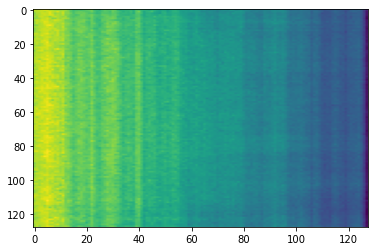

2020-11-05 06:23:43,497 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:56.592394, valid_AUC:0.546090, valid_pAUC:0.499903
100%|██████████| 3452/3452 [00:30<00:00, 114.20it/s]
2020-11-05 06:24:35,006 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:26.448074, valid_AUC:0.498537, valid_pAUC:0.507558
100%|██████████| 3452/3452 [00:30<00:00, 114.61it/s]
2020-11-05 06:25:26,244 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:24.573023, valid_AUC:0.534354, valid_pAUC:0.507931
100%|██████████| 3452/3452 [00:30<00:00, 113.40it/s]
2020-11-05 06:26:17,914 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:21.787036, valid_AUC:0.460909, valid_pAUC:0.491169
100%|██████████| 3452/3452 [00:30<00:00, 114.41it/s]
2020-11-05 06:27:09,135 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:20.389777, valid_AUC:0.473802, valid_pAUC:0.504850
100%|██████████| 3452/3452 [00:30<00:00, 113.57it/s]
2020-11-05 06:28:00,577 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:18.368879, valid_A

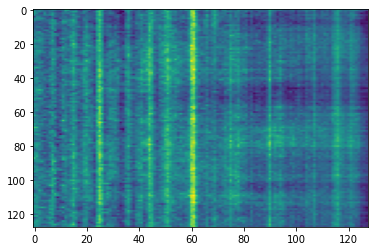

2020-11-05 06:31:25,891 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:18.833300, valid_AUC:0.536753, valid_pAUC:0.498479
100%|██████████| 3452/3452 [00:30<00:00, 112.03it/s]
2020-11-05 06:32:17,815 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:17.565257, valid_AUC:0.530841, valid_pAUC:0.502563
100%|██████████| 3452/3452 [00:30<00:00, 112.86it/s]
2020-11-05 06:33:09,448 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:16.807497, valid_AUC:0.527108, valid_pAUC:0.500838
100%|██████████| 3452/3452 [00:30<00:00, 112.26it/s]
2020-11-05 06:34:01,221 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:16.481646, valid_AUC:0.543071, valid_pAUC:0.504134
100%|██████████| 3452/3452 [00:30<00:00, 112.92it/s]
2020-11-05 06:34:52,845 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:16.069246, valid_AUC:0.540037, valid_pAUC:0.500547
100%|██████████| 3452/3452 [00:30<00:00, 112.98it/s]
2020-11-05 06:35:44,416 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:15.452493, v

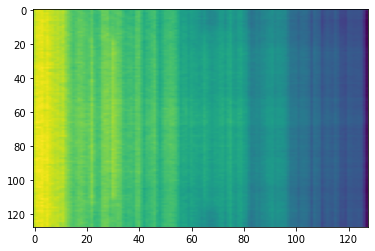

2020-11-05 06:40:03,522 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:14.287172, valid_AUC:0.606698, valid_pAUC:0.519096
100%|██████████| 3452/3452 [00:30<00:00, 113.06it/s]
2020-11-05 06:40:55,157 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:14.111395, valid_AUC:0.513605, valid_pAUC:0.499614
100%|██████████| 3452/3452 [00:30<00:00, 113.06it/s]
2020-11-05 06:41:46,636 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:13.921113, valid_AUC:0.579014, valid_pAUC:0.520779
100%|██████████| 3452/3452 [00:30<00:00, 112.68it/s]
2020-11-05 06:42:38,547 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:13.829274, valid_AUC:0.582864, valid_pAUC:0.516514
100%|██████████| 3452/3452 [00:30<00:00, 112.79it/s]
2020-11-05 06:43:30,284 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:13.518296, valid_AUC:0.583373, valid_pAUC:0.517794
100%|██████████| 3452/3452 [00:30<00:00, 112.40it/s]
2020-11-05 06:44:22,320 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:13.301995, v

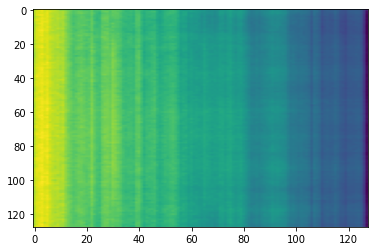

2020-11-05 06:48:40,733 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:13.048681, valid_AUC:0.594186, valid_pAUC:0.517066
100%|██████████| 3452/3452 [00:30<00:00, 113.10it/s]
2020-11-05 06:49:32,445 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:12.935221, valid_AUC:0.567564, valid_pAUC:0.496799
100%|██████████| 3452/3452 [00:30<00:00, 112.73it/s]
2020-11-05 06:50:24,403 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:13.157841, valid_AUC:0.466431, valid_pAUC:0.497383
100%|██████████| 3452/3452 [00:30<00:00, 113.29it/s]
2020-11-05 06:51:15,944 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:13.703085, valid_AUC:0.603570, valid_pAUC:0.521551
100%|██████████| 3452/3452 [00:30<00:00, 112.32it/s]
2020-11-05 06:52:07,741 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:13.163923, valid_AUC:0.581104, valid_pAUC:0.513468
100%|██████████| 3452/3452 [00:30<00:00, 113.08it/s]
2020-11-05 06:52:59,296 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:12.686661, v

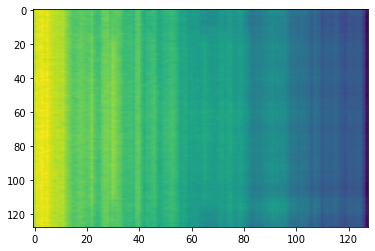

2020-11-05 06:57:18,387 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:12.292123, valid_AUC:0.593416, valid_pAUC:0.515471
100%|██████████| 3452/3452 [00:30<00:00, 112.39it/s]
2020-11-05 06:58:10,168 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:12.409493, valid_AUC:0.591120, valid_pAUC:0.513358
100%|██████████| 3452/3452 [00:30<00:00, 113.09it/s]
2020-11-05 06:59:01,672 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:12.305349, valid_AUC:0.599055, valid_pAUC:0.512585
100%|██████████| 3452/3452 [00:30<00:00, 112.36it/s]
2020-11-05 06:59:53,380 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:11.979859, valid_AUC:0.579771, valid_pAUC:0.510153
100%|██████████| 3452/3452 [00:30<00:00, 113.15it/s]
2020-11-05 07:00:44,954 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:12.116947, valid_AUC:0.585308, valid_pAUC:0.510790
100%|██████████| 3452/3452 [00:30<00:00, 113.02it/s]
2020-11-05 07:01:36,543 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:12.185560, v

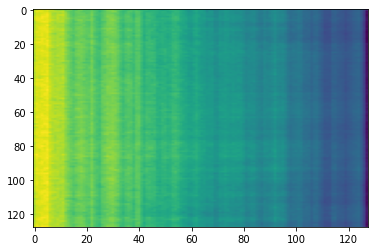

2020-11-05 07:05:55,031 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:12.871654, valid_AUC:0.538207, valid_pAUC:0.500695
100%|██████████| 3452/3452 [00:30<00:00, 113.18it/s]
2020-11-05 07:06:46,692 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:12.158514, valid_AUC:0.600034, valid_pAUC:0.509111
100%|██████████| 3452/3452 [00:30<00:00, 113.47it/s]
2020-11-05 07:07:38,163 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:11.922369, valid_AUC:0.596161, valid_pAUC:0.501161
100%|██████████| 3452/3452 [00:30<00:00, 113.13it/s]
2020-11-05 07:08:29,868 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:11.914926, valid_AUC:0.603976, valid_pAUC:0.509538
100%|██████████| 3452/3452 [00:30<00:00, 113.04it/s]
2020-11-05 07:09:21,634 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:11.820872, valid_AUC:0.604495, valid_pAUC:0.507615
100%|██████████| 3452/3452 [00:30<00:00, 112.26it/s]
2020-11-05 07:10:13,336 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:11.897056, v

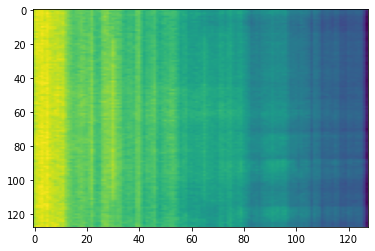

2020-11-05 07:14:32,363 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:11.976853, valid_AUC:0.599866, valid_pAUC:0.513275
100%|██████████| 3452/3452 [00:30<00:00, 113.47it/s]
2020-11-05 07:15:23,882 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:12.411889, valid_AUC:0.566796, valid_pAUC:0.502018
100%|██████████| 3452/3452 [00:30<00:00, 112.37it/s]
2020-11-05 07:16:15,719 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:12.333839, valid_AUC:0.589492, valid_pAUC:0.505821
100%|██████████| 3452/3452 [00:30<00:00, 113.19it/s]
2020-11-05 07:17:07,360 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:12.942664, valid_AUC:0.582699, valid_pAUC:0.507674
100%|██████████| 3452/3452 [00:30<00:00, 112.64it/s]
2020-11-05 07:17:59,128 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:12.175062, valid_AUC:0.581636, valid_pAUC:0.510142
100%|██████████| 3452/3452 [00:30<00:00, 113.33it/s]
2020-11-05 07:18:50,624 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:11.970977, v

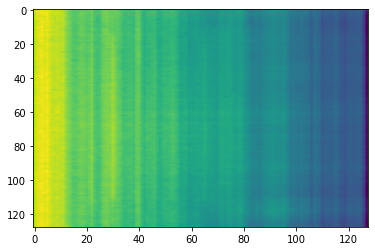

2020-11-05 07:23:08,888 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:11.879803, valid_AUC:0.553166, valid_pAUC:0.499183
100%|██████████| 3452/3452 [00:30<00:00, 112.63it/s]
2020-11-05 07:24:00,639 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:11.683403, valid_AUC:0.539172, valid_pAUC:0.497107
100%|██████████| 3452/3452 [00:30<00:00, 113.38it/s]
2020-11-05 07:24:52,220 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:12.068922, valid_AUC:0.529699, valid_pAUC:0.500353
100%|██████████| 3452/3452 [00:30<00:00, 113.58it/s]
2020-11-05 07:25:43,669 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:12.648138, valid_AUC:0.501681, valid_pAUC:0.493398
100%|██████████| 3452/3452 [00:30<00:00, 113.56it/s]
2020-11-05 07:26:35,260 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:13.502071, valid_AUC:0.505862, valid_pAUC:0.497698
100%|██████████| 3452/3452 [00:30<00:00, 113.61it/s]
2020-11-05 07:27:26,878 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:12.798491, v

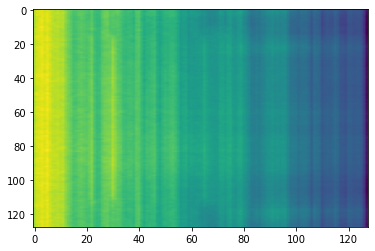

2020-11-05 07:31:45,140 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:11.851316, valid_AUC:0.589900, valid_pAUC:0.512013
100%|██████████| 3452/3452 [00:30<00:00, 113.20it/s]
2020-11-05 07:32:36,826 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:11.763604, valid_AUC:0.584836, valid_pAUC:0.509430
100%|██████████| 3452/3452 [00:30<00:00, 113.44it/s]
2020-11-05 07:33:28,332 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:12.465748, valid_AUC:0.570635, valid_pAUC:0.508538
100%|██████████| 3452/3452 [00:30<00:00, 112.46it/s]
2020-11-05 07:34:20,047 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:12.191348, valid_AUC:0.585850, valid_pAUC:0.505582
100%|██████████| 3452/3452 [00:30<00:00, 113.58it/s]
2020-11-05 07:35:11,503 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:11.899235, valid_AUC:0.584253, valid_pAUC:0.498181
100%|██████████| 3452/3452 [00:30<00:00, 112.65it/s]
2020-11-05 07:36:03,205 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:11.729597, v

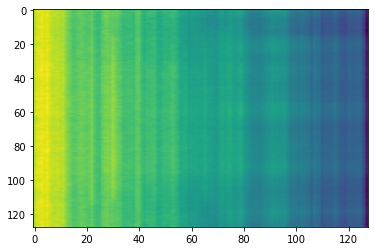

2020-11-05 07:40:21,262 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:12.194975, valid_AUC:0.574425, valid_pAUC:0.500823
100%|██████████| 3452/3452 [00:30<00:00, 113.75it/s]
2020-11-05 07:41:12,619 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:12.243369, valid_AUC:0.576394, valid_pAUC:0.497864
100%|██████████| 3452/3452 [00:30<00:00, 112.81it/s]
2020-11-05 07:42:04,363 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:11.946584, valid_AUC:0.556265, valid_pAUC:0.502012
100%|██████████| 3452/3452 [00:30<00:00, 113.63it/s]
2020-11-05 07:42:55,723 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:12.139733, valid_AUC:0.482126, valid_pAUC:0.496038
100%|██████████| 3452/3452 [00:30<00:00, 113.39it/s]
2020-11-05 07:43:47,193 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:12.862793, valid_AUC:0.553398, valid_pAUC:0.501732
100%|██████████| 3452/3452 [00:30<00:00, 113.70it/s]
2020-11-05 07:44:38,742 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:12.036954, v

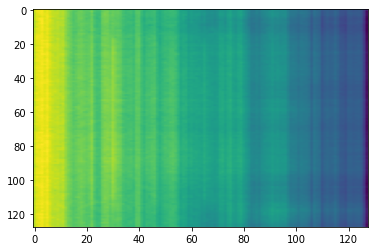

2020-11-05 07:48:56,294 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:11.610564, valid_AUC:0.585597, valid_pAUC:0.506067
2020-11-05 07:48:56,852 - 00_train.py - INFO - 
 success:ToyConveyor 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM3_CONV2_AE/models/ToyConveyor_model.pth


elapsed time: 5165.217520714 [sec]


2020-11-05 07:48:57,865 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2020-11-05 07:48:57,866 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-05 07:48:57,867 - 00_train.py - INFO - TRAINING
  1%|          | 1/182 [00:00<00:20,  8.76it/s]

use: cuda:0


100%|██████████| 855/855 [00:07<00:00, 113.51it/s]


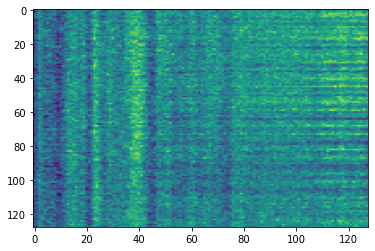

2020-11-05 07:49:26,395 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:91.794947, valid_AUC:0.495319, valid_pAUC:0.499190
100%|██████████| 855/855 [00:07<00:00, 110.87it/s]
2020-11-05 07:49:54,431 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:36.505597, valid_AUC:0.479115, valid_pAUC:0.503904
100%|██████████| 855/855 [00:07<00:00, 114.30it/s]
2020-11-05 07:50:22,489 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:33.162969, valid_AUC:0.463462, valid_pAUC:0.502921
100%|██████████| 855/855 [00:07<00:00, 113.89it/s]
2020-11-05 07:50:50,558 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:27.722392, valid_AUC:0.489670, valid_pAUC:0.501301
100%|██████████| 855/855 [00:07<00:00, 114.18it/s]
2020-11-05 07:51:18,560 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:24.938001, valid_AUC:0.519242, valid_pAUC:0.494014
100%|██████████| 855/855 [00:07<00:00, 114.16it/s]
2020-11-05 07:51:46,564 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:25.944033, valid_AUC:0.47903

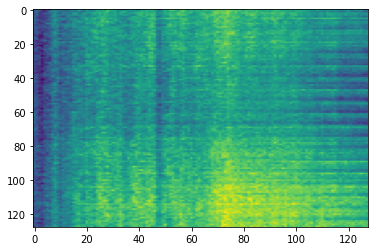

2020-11-05 07:53:38,802 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:24.412991, valid_AUC:0.514934, valid_pAUC:0.513013
100%|██████████| 855/855 [00:07<00:00, 113.05it/s]
2020-11-05 07:54:07,087 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:22.551043, valid_AUC:0.490560, valid_pAUC:0.502400
100%|██████████| 855/855 [00:07<00:00, 114.01it/s]
2020-11-05 07:54:34,962 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:21.778032, valid_AUC:0.470297, valid_pAUC:0.505379
100%|██████████| 855/855 [00:07<00:00, 113.36it/s]
2020-11-05 07:55:03,046 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:19.662620, valid_AUC:0.512555, valid_pAUC:0.507981
100%|██████████| 855/855 [00:07<00:00, 114.66it/s]
2020-11-05 07:55:30,933 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:18.864192, valid_AUC:0.507962, valid_pAUC:0.493262
100%|██████████| 855/855 [00:07<00:00, 113.32it/s]
2020-11-05 07:55:59,075 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:19.971239, valid_AUC:0

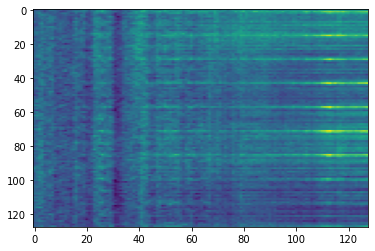

2020-11-05 07:58:19,500 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:15.549221, valid_AUC:0.496434, valid_pAUC:0.498352
100%|██████████| 855/855 [00:07<00:00, 114.27it/s]
2020-11-05 07:58:47,416 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:15.422367, valid_AUC:0.499385, valid_pAUC:0.487276
100%|██████████| 855/855 [00:07<00:00, 114.20it/s]
2020-11-05 07:59:15,325 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:15.137399, valid_AUC:0.506418, valid_pAUC:0.506246
100%|██████████| 855/855 [00:07<00:00, 114.22it/s]
2020-11-05 07:59:43,181 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:14.631182, valid_AUC:0.494434, valid_pAUC:0.492741
100%|██████████| 855/855 [00:07<00:00, 113.73it/s]
2020-11-05 08:00:11,344 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:14.655825, valid_AUC:0.519154, valid_pAUC:0.497860
100%|██████████| 855/855 [00:07<00:00, 113.37it/s]
2020-11-05 08:00:39,468 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:14.430587, valid_AUC:0

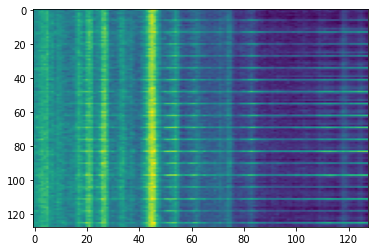

2020-11-05 08:02:59,670 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:14.089000, valid_AUC:0.505346, valid_pAUC:0.497658
100%|██████████| 855/855 [00:07<00:00, 113.79it/s]
2020-11-05 08:03:27,661 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:13.840187, valid_AUC:0.513324, valid_pAUC:0.500868
100%|██████████| 855/855 [00:07<00:00, 111.54it/s]
2020-11-05 08:03:55,759 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:13.753849, valid_AUC:0.493247, valid_pAUC:0.501359
100%|██████████| 855/855 [00:07<00:00, 114.00it/s]
2020-11-05 08:04:23,764 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:13.446342, valid_AUC:0.510357, valid_pAUC:0.499913
100%|██████████| 855/855 [00:07<00:00, 114.10it/s]
2020-11-05 08:04:51,784 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:13.166050, valid_AUC:0.480956, valid_pAUC:0.493031
100%|██████████| 855/855 [00:07<00:00, 114.25it/s]
2020-11-05 08:05:19,679 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:13.248563, valid_AUC:0

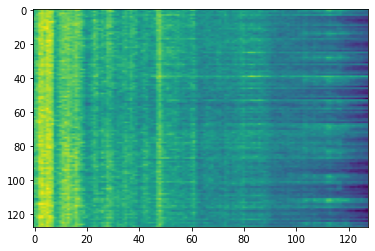

2020-11-05 08:07:40,077 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:12.801402, valid_AUC:0.510643, valid_pAUC:0.500289
100%|██████████| 855/855 [00:07<00:00, 113.87it/s]
2020-11-05 08:08:08,226 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:13.900027, valid_AUC:0.508610, valid_pAUC:0.496935
100%|██████████| 855/855 [00:07<00:00, 114.51it/s]
2020-11-05 08:08:36,149 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:13.163753, valid_AUC:0.520049, valid_pAUC:0.504858
100%|██████████| 855/855 [00:07<00:00, 113.27it/s]
2020-11-05 08:09:04,149 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:12.949614, valid_AUC:0.493566, valid_pAUC:0.497311
100%|██████████| 855/855 [00:07<00:00, 114.21it/s]
2020-11-05 08:09:32,042 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:12.905804, valid_AUC:0.520335, valid_pAUC:0.507663
100%|██████████| 855/855 [00:07<00:00, 112.77it/s]
2020-11-05 08:10:00,143 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:12.661824, valid_AUC:0

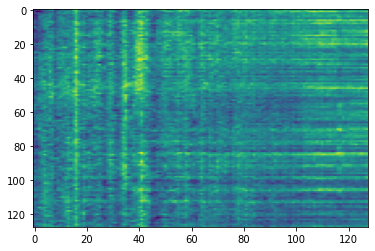

2020-11-05 08:12:20,550 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:12.378255, valid_AUC:0.484956, valid_pAUC:0.497976
100%|██████████| 855/855 [00:07<00:00, 114.51it/s]
2020-11-05 08:12:48,745 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:12.421293, valid_AUC:0.483110, valid_pAUC:0.490226
100%|██████████| 855/855 [00:07<00:00, 113.97it/s]
2020-11-05 08:13:16,817 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:12.310983, valid_AUC:0.482148, valid_pAUC:0.502689
100%|██████████| 855/855 [00:07<00:00, 114.16it/s]
2020-11-05 08:13:44,880 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:12.551030, valid_AUC:0.494297, valid_pAUC:0.497802
100%|██████████| 855/855 [00:07<00:00, 113.73it/s]
2020-11-05 08:14:13,118 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:12.947848, valid_AUC:0.492093, valid_pAUC:0.502805
100%|██████████| 855/855 [00:07<00:00, 113.80it/s]
2020-11-05 08:14:41,107 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:14.500828, valid_AUC:0

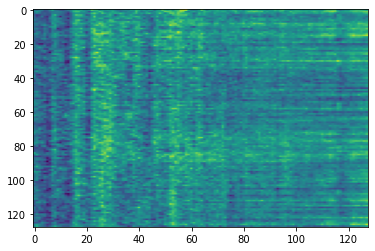

2020-11-05 08:17:01,376 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:12.253579, valid_AUC:0.510478, valid_pAUC:0.493175
100%|██████████| 855/855 [00:07<00:00, 114.65it/s]
2020-11-05 08:17:29,352 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:12.143236, valid_AUC:0.462775, valid_pAUC:0.492308
100%|██████████| 855/855 [00:07<00:00, 113.93it/s]
2020-11-05 08:17:57,442 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:12.069123, valid_AUC:0.488511, valid_pAUC:0.490573
100%|██████████| 855/855 [00:07<00:00, 114.48it/s]
2020-11-05 08:18:25,495 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:12.040189, valid_AUC:0.504791, valid_pAUC:0.493522
100%|██████████| 855/855 [00:07<00:00, 114.19it/s]
2020-11-05 08:18:53,466 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:11.961762, valid_AUC:0.509786, valid_pAUC:0.494361
100%|██████████| 855/855 [00:07<00:00, 114.21it/s]
2020-11-05 08:19:21,494 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:11.822888, valid_AUC:0

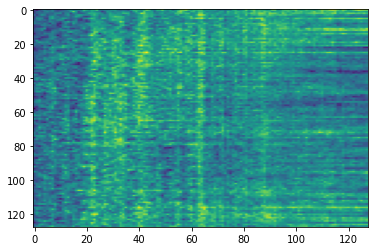

2020-11-05 08:21:41,574 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:11.822596, valid_AUC:0.501374, valid_pAUC:0.498699
100%|██████████| 855/855 [00:07<00:00, 114.19it/s]
2020-11-05 08:22:09,765 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:11.860815, valid_AUC:0.495231, valid_pAUC:0.491961
100%|██████████| 855/855 [00:07<00:00, 113.62it/s]
2020-11-05 08:22:37,905 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:11.756640, valid_AUC:0.495731, valid_pAUC:0.504829
100%|██████████| 855/855 [00:07<00:00, 114.16it/s]
2020-11-05 08:23:05,947 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:11.680417, valid_AUC:0.510978, valid_pAUC:0.502458
100%|██████████| 855/855 [00:07<00:00, 114.65it/s]
2020-11-05 08:23:33,832 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:11.734616, valid_AUC:0.515357, valid_pAUC:0.500000
100%|██████████| 855/855 [00:07<00:00, 113.51it/s]
2020-11-05 08:24:01,949 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:11.910973, valid_AUC:0

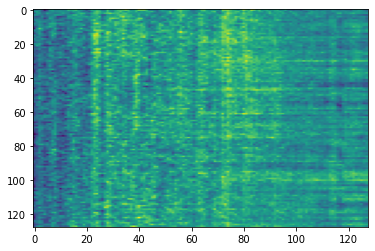

2020-11-05 08:26:22,056 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:11.551915, valid_AUC:0.498797, valid_pAUC:0.497311
100%|██████████| 855/855 [00:07<00:00, 114.38it/s]
2020-11-05 08:26:49,978 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:12.013641, valid_AUC:0.507940, valid_pAUC:0.506478
100%|██████████| 855/855 [00:07<00:00, 114.48it/s]
2020-11-05 08:27:17,925 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:11.760774, valid_AUC:0.503346, valid_pAUC:0.502892
100%|██████████| 855/855 [00:07<00:00, 114.39it/s]
2020-11-05 08:27:45,828 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:11.831313, valid_AUC:0.503978, valid_pAUC:0.508126
100%|██████████| 855/855 [00:07<00:00, 113.82it/s]
2020-11-05 08:28:14,097 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:11.685562, valid_AUC:0.477467, valid_pAUC:0.491903
100%|██████████| 855/855 [00:07<00:00, 114.19it/s]
2020-11-05 08:28:41,985 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:11.529321, valid_AUC:0

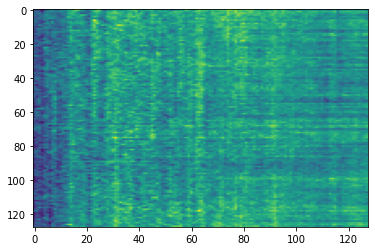

2020-11-05 08:31:02,204 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:11.378826, valid_AUC:0.498621, valid_pAUC:0.512522
100%|██████████| 855/855 [00:07<00:00, 114.39it/s]
2020-11-05 08:31:30,183 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:20.697559, valid_AUC:0.485209, valid_pAUC:0.501909
100%|██████████| 855/855 [00:07<00:00, 113.28it/s]
2020-11-05 08:31:58,268 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:24.435012, valid_AUC:0.460813, valid_pAUC:0.501243
100%|██████████| 855/855 [00:07<00:00, 113.88it/s]
2020-11-05 08:32:26,239 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:23.044486, valid_AUC:0.453879, valid_pAUC:0.492394
100%|██████████| 855/855 [00:07<00:00, 114.08it/s]
2020-11-05 08:32:54,156 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:22.446191, valid_AUC:0.452940, valid_pAUC:0.496732
100%|██████████| 855/855 [00:07<00:00, 114.82it/s]
2020-11-05 08:33:22,117 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:22.098969, valid_AUC:0

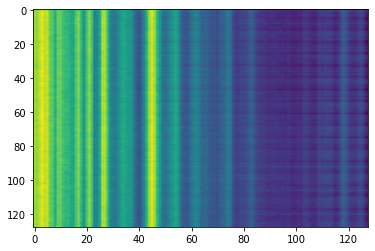

2020-11-05 08:35:42,312 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:21.399679, valid_AUC:0.455324, valid_pAUC:0.497658
2020-11-05 08:35:42,882 - 00_train.py - INFO - 
 success:valve 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM3_CONV2_AE/models/valve_model.pth


elapsed time: 2805.017955065 [sec]


In [11]:
for machine_type in machine_types:
    #if (machine_type == machine_types[0]) or (machine_type == machine_types[1]):
    #    continue
    history = run(machine_type)
    with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
        pickle.dump(history , file)

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)